In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [5]:
conn = MongoClient()
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

In [6]:
df.replace('', np.nan, inplace=True)

In [7]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum().sum()

0

In [8]:
df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)

In [9]:
float_hr = df['hr_value'].values
float_o2 = df['o2_value'].values

In [10]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences[0])):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences[0])-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[0][i:end_ix].reshape(len(sequences[0][i:end_ix]),1) 
        seq_x = np.append(seq_x, sequences[1][i:end_ix].reshape(len(sequences[1][i:end_ix]),1), axis=1)
        seq_y1, seq_y2 =  sequences[0][end_ix] ,sequences[1][end_ix]
        X.append(seq_x)
        y.append([seq_y1,seq_y2])
    return np.array(X), np.array(y)

In [11]:
# this split will predict next value
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
dataset = np.array([in_seq1, in_seq2])
n_steps = 3
X, y = split_sequences(dataset, n_steps)
for i in range(len(X)):
    print(X[i], y[i])

[[10 15]
 [20 25]
 [30 35]] [40 45]
[[20 25]
 [30 35]
 [40 45]] [50 55]
[[30 35]
 [40 45]
 [50 55]] [60 65]
[[40 45]
 [50 55]
 [60 65]] [70 75]
[[50 55]
 [60 65]
 [70 75]] [80 85]
[[60 65]
 [70 75]
 [80 85]] [90 95]


In [12]:
dataset = np.array([float_hr, float_o2])
n_steps = 3
X, y = split_sequences(dataset, n_steps)
for i in range(4):
    print(X[i], y[i][0])

[[84. 95.]
 [84. 95.]
 [84. 95.]] 84.0
[[84. 95.]
 [84. 95.]
 [84. 95.]] 79.0
[[84. 95.]
 [84. 95.]
 [79. 98.]] 79.0
[[84. 95.]
 [79. 98.]
 [79. 98.]] 79.0


In [192]:
n_features = 2
model = Sequential()
model.add(layers.convolutional.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(layers.convolutional.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50 ,activation='relu'))
model.add(layers.Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 2, 64)             320       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 102       
Total params: 3,672
Trainable params: 3,672
Non-trainable params: 0
_________________________________________________________________


In [207]:
history = model.fit(X, y, epochs=1000, verbose=0, batch_size=128, validation_split=0.2)

<IPython.core.display.Javascript object>


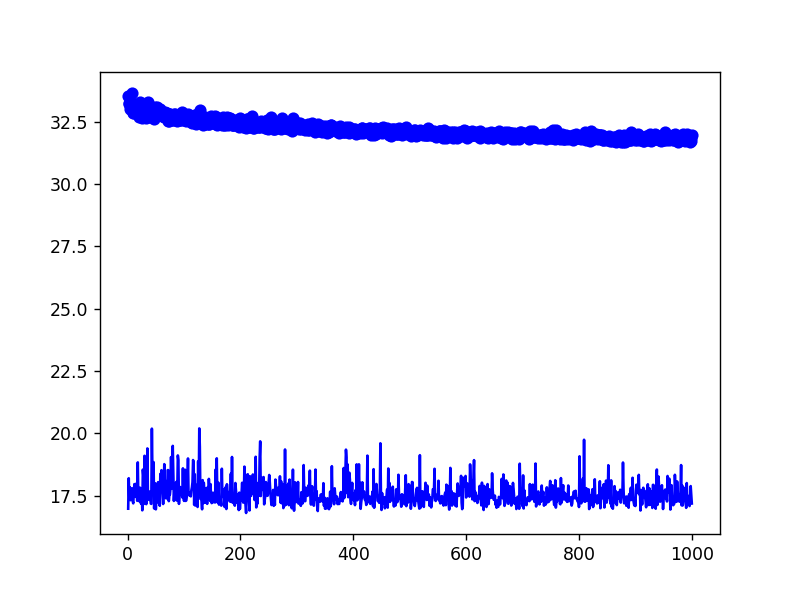

In [208]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [13]:
dftspdiff = df['timestamp'].diff()
dftfdiffSTD = dftspdiff.rolling(20).std()

# find the place that std is smaller than 5
lis = []
changeFlag = 0
tempt = [0]
for i in range(len(dftfdiffSTD)):
    if dftfdiffSTD[i] < 5 and changeFlag == True and len(tempt) < 2:
        tempt.append(i)
        changeFlag = False
    if dftfdiffSTD[i] >= 5 and changeFlag == False and len(tempt) < 2:
        tempt.append(i-1)
        changeFlag = True
    if len(tempt) == 2:
        lis.append(tempt)
        tempt = []
print(lis)

[[0, 108], [212, 238], [259, 371], [407, 511], [532, 650], [672, 782], [805, 830], [1072, 1176], [1197, 1485], [1506, 1757], [1845, 1867], [1888, 2240], [2261, 2263], [2313, 2381], [2466, 2859], [2994, 3101], [3129, 3864], [3980, 4169], [4275, 4373], [4448, 4797], [4818, 4986], [5018, 5024], [5115, 5533], [5554, 5886], [5912, 5926], [6046, 6065], [6087, 6151], [6265, 6295], [6360, 6420], [6554, 6582], [6619, 6624], [6683, 6748], [6769, 6820], [6886, 6948], [6970, 7108], [7129, 7137], [7169, 7193], [7373, 7507], [7554, 7671], [7714, 7738], [7761, 7852], [7874, 7905], [7979, 8428], [8576, 8598], [8680, 8735], [8758, 8905], [8929, 8968], [9013, 9135], [9163, 9207], [9309, 9349], [9386, 9454], [9513, 9747], [9782, 10038], [10059, 10346], [10504, 10518], [10523, 10532], [10539, 10541], [10577, 10656], [10711, 10808], [10856, 10966], [11005, 11276], [11297, 11371], [11418, 11426], [11459, 11700], [11763, 11778], [11799, 14477], [14498, 14706], [14738, 15224], [15245, 15379], [15443, 15465], 

In [18]:
dim = len(lis)
new_float_hr = []
for i in lis:
    new_float_hr.append(float_hr[i[0]:i[1]])

In [19]:
new_float_hr = np.array(new_float_hr)
print(dim)

141


In [ ]:
newinput = []
for i in lis:
    dataset = np.array([float_hr[i[0]:i[1]], float_o2[i[0]:i[1]]])
    n_steps = 3
    X, y = split_sequences(dataset, n_steps)
    newinput.append(X,y)
for i in range(4):
    print(X[i], y[i][0])

In [20]:
type(X)

numpy.ndarray

In [217]:
n_features = 2
visible = Input(shape=(n_steps, n_features))
cnn = Conv1D(filters= 64, kernel_size=2, activation='relu')(visible)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(50, activation='relu')(cnn)
# define output 1
output1 = Dense(1)(cnn)
# define output 2
output2 = Dense(1)(cnn)
# tie together
model = Model(inputs=visible, output=[output1, output2])
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X, [y[:, 0], y[: ,1]], epochs=2000, verbose=0)

/home/james/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  if sys.path[0] == '':


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3, 2)         0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 2, 64)        320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 1, 64)        0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 64)           0           max_pooling1d_9[0][0]            
__________________________________________________________________________________________________
dense_18 (

KeyboardInterrupt: 

In [ ]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix].reshape(len(sequences[i:end_ix]),1) 
        seq_y =  sequences[end_ix]
        X.append(seq_x)
        y.append([seq_y])
    return np.array(X), np.array(y)